# Environment: Pendulum


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import clear_output
from keras.utils import to_categorical
import seaborn as sns
from copy import copy
sns.set()
# We import the agents and the environment from the 
# modules created in advance.
from analyzers import Two_Layers_single_output

class Pendulum(object):
    def __init__(self, g=9.8, L_min=0.1, L_max=1, M_min=0.1, M_max=1, max_reward=1):
        self.max_reward = max_reward
        self.g = g
        self.M_min = M_min
        self.M_max = M_max
        self.L_min = L_min
        self.L_max = L_max
        self.M = random.uniform(self.M_min, self.M_max)
        self.L = random.uniform(self.L_min, self.L_max)
        self.T = 2*np.pi*np.sqrt(self.L/self.g)
        self.total_reward = 0
        reward = 0
    def restart_values(self):
        self.M = random.uniform(self.M_min, self.M_max)
        self.L = random.uniform(self.L_min, self.L_max)
        self.T = 2*np.pi*np.sqrt(self.L/self.g)
    def take_action(self, action):
        return self.M if action==0 else self.L
    # def test(self):
    #     test_pre = random.uniform(self.x_min,self.x_max)
    #     test_post = test_pre*self.x_arms[self.target_arm]
    #     return test_pre, test_post

    def give_reward(self, prediction, observed, sigma=0.05):
        x = (observed-prediction)/observed
        reward = self.max_reward*np.exp(-0.5*(x/sigma)**2)
        self.total_reward = self.total_reward + reward
        return reward
    def reshape_for_analyzer(self, measurements, target):
        """ Reshapes the measurements and the target value in a suitable
        format for a Keras analyzer
        
        :param measurements: Measurements to give the Analyzer to make the 
                             prediction
        :type measurements: numpy array
        :param target: Target value to fit.
        :type target: float
        :return: X_train (inputs to the Analyzer), y_train (Target value to fit)
        :rtype: pandas DataFrame, pandas DataFrame
        """        
        X_train = pd.DataFrame(measurements.reshape(-1,len(measurements)))
        y_train = pd.DataFrame(target*np.ones((1,1)))
        return X_train, y_train
    def get_measurements(self, outcome):
        """ Transforms the actions and the environmental elements into an array
        to feed the Analyzer.
        
        :param outcome: Outcome obtained by the experimenter
        :type outcome: float
        :return: Numpy array containing all the arguments
        :rtype: numpy array
        """        
        return np.array([outcome])

Using TensorFlow backend.


In [3]:
class Simple_Experimenter(object):
    def __init__(self, iterations, output_size, exploration_rate=1, learning_rate = 0.1):
        self.iterations = iterations
        self.output_size = output_size
        self.Q = output_size*[0]
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.exploration_delta = 1/self.iterations
        self.q = []
        self.marker = 0
    def greedy_action(self):
        return np.argmax(self.Q)
    def random_action(self):
        return 0 if random.random()<0.5 else 1
    def get_next_action(self):
        return self.greedy_action() if random.random()>self.exploration_rate else self.random_action()
    def train(self, action, reward):
        self.Q[action] += self.learning_rate*reward
        if self.exploration_rate > 0:
            self.exploration_rate-=1.3*self.exploration_delta
            self.marker += 1

10000/10000 episodes(100.0%)
Elapsed time: 0 min 54s
Est. completion time: 0 min 54s,
        Est. remaining time: 0 min 0s
Training completed!


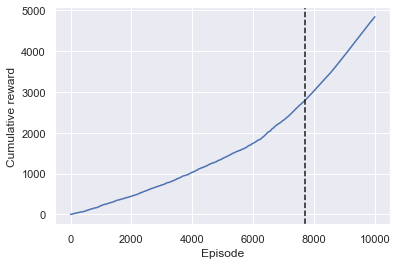

,M,L,Action,Outcome,Reward,Predicted T,Real T,q0,q1,Exploration rate
0,0.6995,0.5099,1,0.5099,0.0000,0.0000,1.4332,0.0000,0.0000,1.0000
1,0.6038,0.6480,1,0.6480,0.0000,-0.3836,1.6156,0.0000,0.0000,0.9999
2,0.2450,0.6058,0,0.2450,0.0000,0.1028,1.5622,0.0000,0.0000,0.9997
3,0.2586,0.7311,0,0.2586,0.0000,0.3770,1.7162,0.0000,0.0000,0.9996
4,0.5633,0.3698,1,0.3698,0.0000,0.6202,1.2205,0.0000,0.0000,0.9995
...,...,...,...,...,...,...,...,...,...,...
9995,0.8152,0.5430,1,0.5430,0.9783,1.4945,1.4790,27.7175,456.1778,-0.0001
9996,0.4695,0.1391,1,0.1391,0.8685,0.7684,0.7485,27.7175,456.2647,-0.0001
9997,0.3605,0.4795,1,0.4795,0.9518,1.4116,1.3898,27.7175,456.3599,-0.0001
9998,0.7222,0.2612,1,0.2612,0.8816,1.0516,1.0259,27.7175,456.4480,-0.0001


In [4]:
# CONSTANTS, INSTANTIATIONS, INITIALIZATION ===============================
N_Episodes = 10000 # Number of episodes to train 
count = 0 # Initialization of a counter
# We instantiate the classes of each element
experimenter = Simple_Experimenter(iterations=N_Episodes, output_size=2)
analyzer = Two_Layers_single_output(input_size=1,learning_rate=0.1)
env = Pendulum()
# Save time for verbose purposes
t0 = time.time()
t1 = time.time()

# First random initialization of the variables. This part is needed since 
# some recurrent parts of the loop need from some data to start with.
action = experimenter.get_next_action()
outcome = env.take_action(action)
y_predicted = [0]
reward = 0

# Auxiliar variables for collecting data
values = []
df=pd.DataFrame(columns = ['M','L', 'Action', 'Outcome', 'Reward', 
                           'Predicted T', 'Real T', 'q0','q1','Exploration rate'])
total_reward_list = []

# MAIN LOOP =================================================================

while count < N_Episodes:
    values.append([env.M, env.L, 
                   action, outcome, float(reward),
                   y_predicted[0], env.T, float(experimenter.Q[0]), float(experimenter.Q[1]), experimenter.exploration_rate])
    total_reward_list.append(env.total_reward)
    env.restart_values()
    action = experimenter.get_next_action()
    outcome = env.take_action(action)
    measurements = env.get_measurements(outcome)
    X, y = env.reshape_for_analyzer(measurements, env.T)
    y_predicted = analyzer.predict(X)[0]
    reward = env.give_reward(y_predicted, env.T)
    experimenter.train(action, reward)
    analyzer.train(X, y)
# Display training status....................................................
    count = count + 1
    refresh_rate = 20
    if count % (N_Episodes/refresh_rate) == 0:
        clear_output()
        t2 = time.time()
        m, s = divmod(t2-t1, 60)
        mt, st = divmod(t2-t0, 60)
        me, se = divmod(((t2-t0)/count)*N_Episodes, 60)
        mr, sr = divmod(((t2-t0)/count)*N_Episodes-t2+t0, 60)
        print (str(int(count)) + '/' +  str(N_Episodes) + " episodes" + 
               '(' + str(100*count/N_Episodes)+ '%)')
        print('Elapsed time: {} min {}s'.format(int(mt), int(st)))
        print("""Est. completion time: {} min {}s,
        Est. remaining time: {} min {}s""".format(int(me), int(se), int(mr),
                                                  int(sr)))
        t1 = time.time()
print('Training completed!')


plt.plot(range(len(total_reward_list)), total_reward_list)
plt.axvline(x=experimenter.marker,color='k',linestyle='--')
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()


df=pd.DataFrame(values, columns = ['M','L', 'Action', 'Outcome', 'Reward', 
                           'Predicted T', 'Real T', 'q0','q1', 'Exploration rate'])
df.to_csv('pendulum.csv')
df.round(4)

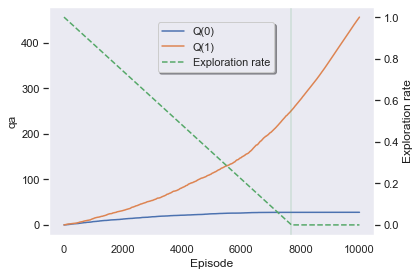

In [18]:
fig, ax1 = plt.subplots()
color = 'k'
ax1.set_ylabel('qa')
ax1.set_xlabel('Episode', color=color)
ax1.plot(range(len(df)),df['q0'],label='Q(0)')
ax1.plot(range(len(df)),df['q1'],label='Q(1)')
# ax1.plot(range(len(df['Action'])),df['Action'],label='a=1')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Exploration rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df['q1'])),df['Exploration rate'],'g--', label = 'Exploration rate')
ax2.tick_params(axis='y', labelcolor=color)
plt.axvline(x=experimenter.marker,color='g',linestyle='-',alpha=0.2)
ax2.grid(False)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), shadow=True, ncol=1)
fig.tight_layout()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('Q-Values-Pendulum.pdf')

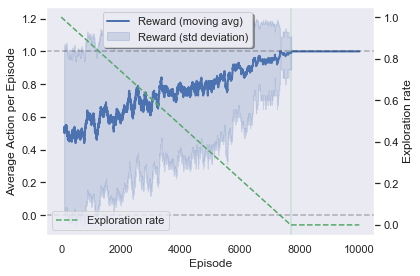

In [21]:
fig, ax1 = plt.subplots()
color = 'k'
window = int(N_Episodes/100)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Action per Episode', color=color)
smooth_path= df['Action'].rolling(window=window).mean()
path_deviation = df['Action'].rolling(window=window).std()
under_line     = (smooth_path-path_deviation)
over_line      = (smooth_path+path_deviation)
ax1.plot(smooth_path, linewidth=2, label ='Reward (moving avg)') #mean curve.
ax1.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=0.2,label ='Reward (std deviation)') #std curves.
ax1.axhline(y=1,color='k',linestyle='--',alpha=0.3)
ax1.axhline(y=0,color='k',linestyle='--',alpha=0.3)
ax1.legend(loc='upper center', bbox_to_anchor=(0.4, 1), shadow=True, ncol=1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Exploration rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df['q1'])),df['Exploration rate'],'g--', label = 'Exploration rate')
ax2.tick_params(axis='y', labelcolor=color)
plt.axvline(x=experimenter.marker,color='g',linestyle='-',alpha=0.2)
ax2.grid(False)
ax2.legend()
fig.tight_layout()
plt.savefig('Avg-Action-Pendulum.pdf')

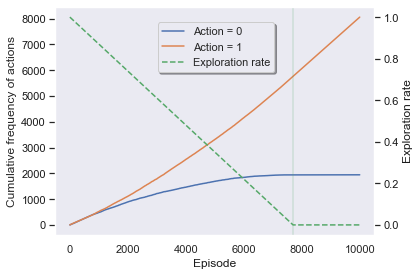

In [15]:
cumulative_frequency_0 = []
cumulative_frequency_1 = []
counter_0 = 0
counter_1 = 1
for i in range(len(df)):
    if df['Action'][i]==0:
        counter_0+=1
    else:
        counter_1+=1
    cumulative_frequency_0.append(counter_0)
    cumulative_frequency_1.append(counter_1)

fig, ax1 = plt.subplots()
color = 'k'
ax1.set_ylabel('Cumulative frequency of actions')
ax1.set_xlabel('Episode', color=color)
ax1.plot(range(len(df['Action'])),cumulative_frequency_0,label='Action = 0')
ax1.plot(range(len(df['Action'])),cumulative_frequency_1,label='Action = 1')
# ax1.plot(range(len(df['Action'])),df['Action'],label='a=1')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Exploration rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df['q1'])),df['Exploration rate'],'g--', label = 'Exploration rate')
ax2.tick_params(axis='y', labelcolor=color)
plt.axvline(x=experimenter.marker,color='g',linestyle='-',alpha=0.2)
ax2.grid(False)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), shadow=True, ncol=1)
fig.tight_layout()
plt.savefig('Cum-Freq-Pendulum.pdf')

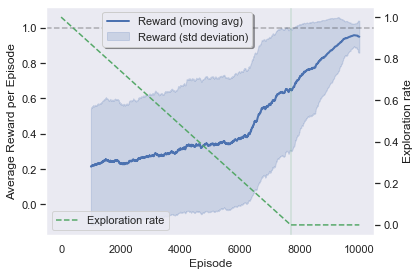

In [24]:
fig, ax1 = plt.subplots()
color = 'k'
window = int(N_Episodes/10)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward per Episode', color=color)
smooth_path= df['Reward'].rolling(window=window).mean()
path_deviation = df['Reward'].rolling(window=window).std()
under_line     = (smooth_path-path_deviation)
over_line      = (smooth_path+path_deviation)
ax1.plot(smooth_path, linewidth=2, label ='Reward (moving avg)') #mean curve.
ax1.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=0.2,label ='Reward (std deviation)') #std curves.
ax1.axhline(y=1,color='k',linestyle='--',alpha=0.3)
ax1.legend(loc='upper center', bbox_to_anchor=(0.4, 1), shadow=True, ncol=1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Exploration rate', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df['q1'])),df['Exploration rate'],'g--', label = 'Exploration rate')
ax2.tick_params(axis='y', labelcolor=color)
plt.axvline(x=experimenter.marker,color='g',linestyle='-',alpha=0.2)
ax2.grid(False)
ax2.legend()
fig.tight_layout()
plt.savefig('Reward-Pendulum.pdf')

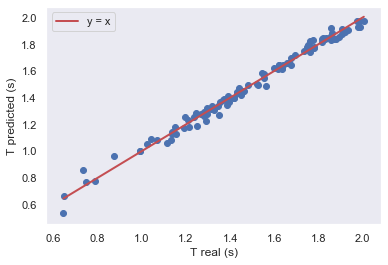

In [22]:
sample_size = 0.01
sample=df.loc[np.r_[N_Episodes-N_Episodes*sample_size:N_Episodes], :]
plt.scatter(sample['Real T'],sample['Predicted T'])
x=[min(sample['Real T']),max(sample['Real T'])]
plt.plot(x,x,'r-',label='y = x',linewidth =2)
plt.ylabel( 'T predicted (s)')
plt.xlabel('T real (s)')
plt.legend()
plt.grid(False)
plt.savefig('Real-vs-Pred-Pendulum.pdf')